# Simulating Basilisk market through 100 runs of 10,000 timesteps each, with progressively increasing trade volume
Each timestep, the two Trader agents make equal and opposite trades from R1 to R2 and back again. These trades cancel each other out, accumulating fees without affecting the prices of the assets. Instead, the asset prices change randomly throughout each simulation, by up to 0.05% per time step. The trade volume per time step ranges from 0 USD on the first run to 200 at the 10th. This allows us to measure liquidity provider profits as a function of trade volume.

In [1]:
import random
import sys
import matplotlib.pyplot as plt
from IPython.display import clear_output
sys.path.append('../..')

from model import run
from model import plot_utils as pu
from model import processing
from model.amm.basilisk_amm import ConstantProductPoolState
from model.amm.agents import Agent
from model.amm.trade_strategies import steady_swaps, constant_product_arbitrage, invest_all
from model.amm.global_state import GlobalState, fluctuate_prices, oscillate_prices

# same seed, same parameters = same simulation result
random.seed(42)

price_dict = {
    'R1': 3,
    'R2': 0.7,
    'USD': 1
}

initial_state = GlobalState(
    pools={
        'R1/R2': ConstantProductPoolState(
            tokens={
                'R1': 9000000 / price_dict['R1'],
                'R2': 9000000 / price_dict['R2']
            },
            trade_fee=0.01
        )
    },
    agents = {
        'LP': Agent(
            holdings={'R1': 1000000 / price_dict['R1'], 'R2': 1000000 / price_dict['R2']},
            trade_strategy=invest_all('R1/R2')
        ),
        'Trader1': Agent(
            holdings={'R1': 10000000, 'R2': 42000000}
        ),
        'Trader2': Agent(
            holdings={'R1': 10000000, 'R2': 42000000}
        ),
        'Arbitrageur': Agent(
            holdings={'USD': 1000000},
            trade_strategy=constant_product_arbitrage('R1/R2')
        )
    },
    external_market=price_dict,
    evolve_function=fluctuate_prices(volatility={'R1': 0.05, 'R2': 0.05})
)

events = []
runs = 100
time_steps = 10000
trade_factor = 2
for i in range(runs):
    # have the traders trade in opposite directions so it won't force equal levels of arbitrage
    copy_state = initial_state.copy()
    copy_state.agents['Trader1'].trade_strategy=steady_swaps(
        pool_id='R1/R2',
        usd_amount=trade_factor*i,
        asset_list=['R1', 'R2']
    )
    copy_state.agents['Trader2'].trade_strategy=steady_swaps(
        pool_id='R1/R2',
        usd_amount=trade_factor*i,
        asset_list=['R2', 'R1']
    )
    clear_output(wait=True)
    print(f'Running simulation... {int(i/runs * 100)}%')
    events.append(
        run.run(copy_state, time_steps=time_steps, silent=True),
    )

print('finished.')

Running simulation... 99%
finished.


In [7]:
from model.amm.global_state import withdraw_all_liquidity

arb_volume=[]
arbitrage_fraction=[]
LP_profit = []
LP_profit_measured_first = []
LP_profit_measured_last = []

print('Post-processing... 0%')

def holdings_in_asset(denomination: str, state: GlobalState, agent: Agent) -> float:
    return processing.value_assets(
        {tkn: state.external_market[tkn] / state.external_market[denomination] for tkn in state.asset_list}, 
        withdraw_all_liquidity(state, agent.unique_id).agents[agent.unique_id]
    )

print(len(events))
    
for i, run in enumerate(events):
    
    clear_output(wait=True)
    print(f'Post-processing...  {int(i/runs * 100)}%')
    
#     trader_volume = sum(
#         pu.get_datastream(run, agent='Trader1', prop='trade_volume') +
#         pu.get_datastream(run, agent='Trader2', prop='trade_volume')
#     )
    
#     arb_volume.append(sum(
#         pu.get_datastream(run, agent='Arbitrageur', prop='trade_volume')
#     ))
    
#     arbitrage_fraction.append(arb_volume[-1] / (arb_volume[-1] + trader_volume))
    
    LP_profit.append(
        processing.cash_out(run[-1]['state'], run[-1]['state'].agents['LP'])
        - processing.cash_out(run[0]['state'], run[0]['state'].agents['LP'])
    )
    
    LP_profit_measured_first.append(
        processing.value_assets(run[0]['state'].external_market, withdraw_all_liquidity(run[-1]['state'], 'LP').agents['LP']) - 
        processing.value_assets(run[0]['state'].external_market, withdraw_all_liquidity(run[0]['state'], 'LP').agents['LP'])
    )
    LP_profit_measured_last.append(
        processing.value_assets(run[-1]['state'].external_market, withdraw_all_liquidity(run[-1]['state'], 'LP').agents['LP']) - 
        processing.value_assets(run[-1]['state'].external_market, withdraw_all_liquidity(run[0]['state'], 'LP').agents['LP'])
    )
    # for i in range(len(run)):
    #     run[i]['state'].agents['LP'].r1_val = processing.value_assets(
    #         {'USD': 0, 'R1': 1, 'R2': run[i]['state'].external_market['R2'] / run[i]['state'].external_market['R1']}, 
    #         withdraw_all_liquidity(run[i]['state'], 'LP').agents['LP']
    #     )
    # LP_profit_R1.append(
    #     (
    #         holdings_in_asset('R1', run[-1]['state'], run[-1]['state'].agents['LP']) - 
    #         holdings_in_asset('R1', run[0]['state'], run[0]['state'].agents['LP'])
    #     )
    #     / (
    #         processing.value_assets(run[-1]['state'].external_market, withdraw_all_liquidity(run[-1]['state'], 'LP').agents['LP']) /
    #         processing.value_assets(run[0]['state'].external_market, withdraw_all_liquidity(run[0]['state'], 'LP').agents['LP'])
    #     )
    # )

Post-processing...  99%


LP profit in USD per time step with 1.0% trade fee, and 0.05% volatility, where v = trade volume:
profit = 0.004v


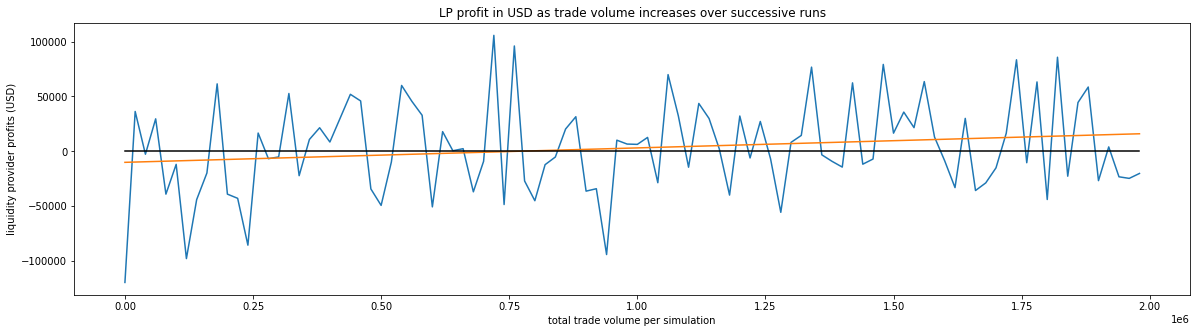

In [26]:
# plt.figure(figsize=(20, 5))
# plt.subplot(111, title='LP profit as a function of arbitrage percentage')
# # plt.xscale('log')
# sorted_profit= [i for _, i in sorted(zip(arbitrage_fraction, LP_profit))]
# plt.plot(arbitrage_fraction, LP_profit)
# # plt.plot([min(arbitrage_fraction), max(arbitrage_fraction)], [0, 0]) 
# plt.show()

plt.figure(figsize=(20, 5))

ax = plt.subplot(111, title='LP profit in USD as trade volume increases over successive runs')
ax.set_xlabel('total trade volume per simulation')
ax.set_ylabel('liquidity provider profits (USD)')

# ax.plot(range(len(arb_volume)), arb_volume)
# ax.plot(*pu.best_fit_line(arb_volume))

trade_volume = [i * trade_factor * time_steps for i in range(runs)]
ax.plot(trade_volume, LP_profit)
# ax.plot(trade_volume, LP_profit)
# ax.plot([trade_volume[0], trade_volume[-1]], [0, 0])
ax.plot(trade_volume, pu.best_fit_line(LP_profit)[1])
ax.plot([min(trade_volume), max(trade_volume)], [0, 0], color='black')
# ax.plot(trade_volume, [(LP_profit_measured_first[i] + LP_profit_measured_last[i]) / 2 for i in range(runs)])
best_fit = pu.best_fit_line(LP_profit_measured_last)[1]
print(f'LP profit in USD per time step with {round(initial_state.pools["R1/R2"].base_fee * 100, 2)}% trade fee, and 0.05% volatility, where v = trade volume:')
print(f'profit = {round((best_fit[-1] - best_fit[0]) / runs / time_steps, 3)}v')

# Accounting for impermanent loss
This initial graph has a low signal to noise ratio. Part of the reason is impermanent loss. Impermanent loss occurs when the assets in the pool change in price relative to each other, decreasing returns for liquidity providers. It's measured here as
#### (LP profits at initial market prices) - (LP profits at ending market prices)
This is zero when there is no price shift between the beginning and end of the run (1.0) and goes negative if the relative price moves in either direction.

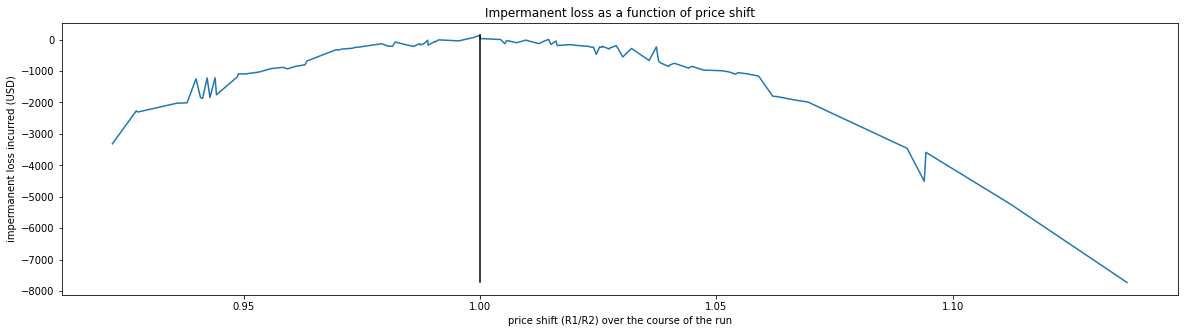

In [29]:
impermanent_loss = [(LP_profit_measured_last[i] - LP_profit_measured_first[i]) for i in range(runs)]
price_shift = [
    (run[0]['state'].external_market['R1'] / run[0]['state'].external_market['R2']) /
    (run[-1]['state'].external_market['R1'] / run[-1]['state'].external_market['R2'])
    for run in events
]
ordered_pairs = sorted(zip(price_shift, impermanent_loss), key=lambda x: x[0])
ordered_price_shift = [pair[0] for pair in ordered_pairs]
ordered_impermanent_loss = [pair[1] for pair in ordered_pairs]

plt.figure(figsize=(20, 5))

ax = plt.subplot(111, title='Impermanent loss as a function of price shift')
ax.set_xlabel('price shift (R1/R2) over the course of the run')
ax.set_ylabel('impermanent loss incurred (USD)')
ax.plot(ordered_price_shift, ordered_impermanent_loss)
ax.plot([1, 1], [min(impermanent_loss), max(impermanent_loss)], color='black')

# Final profit calculation
We can subtract impermanent loss from net change to isolate "real" LP profit. The best fit line has the same slope, but the signal to noise ratio is much better.

LP profit in USD per time step with 1.0% trade fee, and 0.05% volatility, where v = trade volume:
profit = 0.004v


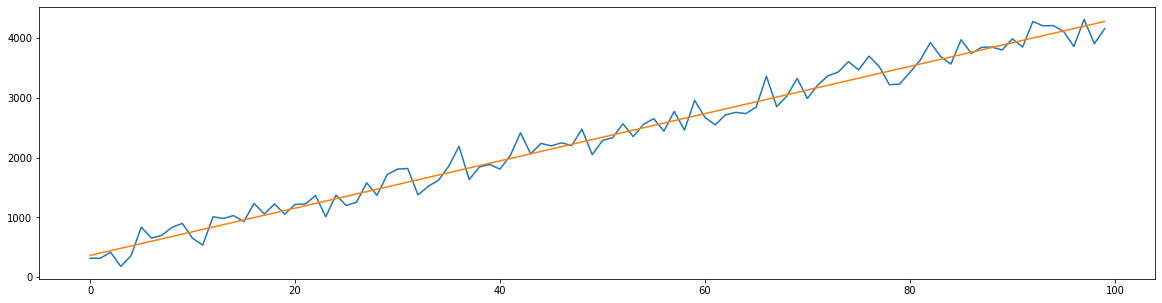

In [30]:
real_LP_profit = [LP_profit_measured_last[i] - impermanent_loss[i]/2 for i in range(runs)]
plt.figure(figsize=(20,5))
ax = plt.subplot(111)
ax.plot(range(runs), real_LP_profit)
best_fit = pu.best_fit_line(real_LP_profit)[1]
ax.plot(range(runs), best_fit)

print(f'LP profit in USD per time step with {round(initial_state.pools["R1/R2"].base_fee * 100, 2)}% trade fee, and 0.05% volatility, where v = trade volume:')
print(f'profit = {round((best_fit[-1] - best_fit[0]) / runs / time_steps, 3)}v')

In [ ]:
# plt.figure(figsize=(20, 5))
# color = [f'#{hex(int(i * 255 / runs))[2:].zfill(2)}00{hex(int(255 - i * 255 / runs))[2:].zfill(2)}' for i in range(runs)]
# for i, run in enumerate(events):
#     liquidity_r1 = pu.get_datastream(run, pool='R1/R2', prop='liquidity', key='R1')
#     liquidity_r2 = pu.get_datastream(run, pool='R1/R2', prop='liquidity', key='R2')
#     price_r1 = run[0]['state'].price('R1')
#     price_r2 = run[0]['state'].price('R2')

#     plt.plot(range(time_steps), [liquidity_r1[i] * price_r1 + liquidity_r2[i] * price_r2  for i in range(time_steps)], color=color[i])
    
# plt.figure(figsize=(20, 5))
# for run in events:
#     plt.plot(range(time_steps), pu.get_datastream(run, pool='R1/R2', prop='pool_val'))